# Camada RAW – Análise Exploratória de Dados

## Descrição Geral

Este notebook tem como propósito realizar o **carregamento e a análise inicial** dos dados inseridos na **camada RAW** da Data Layer.  
Nessa etapa, são utilizados os arquivos brutos extraídos de diferentes fontes, sem qualquer tipo de pré-processamento. O objetivo é compreender a estrutura, qualidade e composição dos dados antes que eles avancem para as camadas de transformação (Bronze, Silver e Gold).

## Configuração Inicial

A primeira parte do notebook é dedicada à preparação do ambiente de trabalho, incluindo:

- **Importação das bibliotecas essenciais**, como `pandas`, `numpy`, `matplotlib` e `seaborn`, com breve explicação de seus papéis na análise.  
- **Definição dos caminhos** para os arquivos localizados na camada RAW.  
- **Levantamento de metadados** iniciais, como tipos de dados, quantidade de registros, presença de valores nulos e possíveis erros de formatação.

Ao final desta etapa, espera-se ter uma visão clara sobre a **qualidade e estrutura dos dados brutos**.


In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql.functions import col, count, desc, floor, lit
import seaborn as sns
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder
    .appName("Formula1Analysis")
    .master("local[*]") 
    .config("spark.driver.memory", "4g") 
    .config("spark.executor.memory", "4g") 
    .getOrCreate()
)

if spark.sparkContext.appName == "Formula1Analysis":
    print("✅ Configuração do PySpark concluída com sucesso.")
    print(f"Versão do Spark: {spark.version}")
    print(f"Modo de execução: {spark.conf.get('spark.master')}")
else:
    print("❌ Erro na configuração do PySpark.")

✅ Configuração do PySpark concluída com sucesso.
Versão do Spark: 4.0.1
Modo de execução: local[*]


___

### Alocação dos dados em dataframes no PySpark

Esta célula carrega os arquivos CSV como DataFrames do PySpark, aplicando opções importantes como inferência de esquema e tratamento de valores nulos (\N).

In [ ]:
BASE_PATH = "dados_brutos/"

files = [
    'constructor_results.csv',
    'constructor_standings.csv',
    'constructors.csv',
    'driver_standings.csv',
    'drivers.csv',
    'lap_times.csv',
    'pit_stops.csv',
    'qualifying.csv',
    'races.csv',
    'results.csv'
]

read_options = {
    "header": True,
    "inferSchema": True,
    "nullValue": '\\N',
    "sep": ","
}

for file_name in files:
    full_path = BASE_PATH + file_name
    
    df_name = file_name.replace('.csv', '_df')
    
    try:
        df = spark.read.csv(full_path, **read_options)
        
        globals()[df_name] = df
        
        print(f"✅ DataFrame '{df_name}' criado a partir de '{full_path}'.")
        
    except Exception as e:
        print(f"❌ Erro ao carregar o arquivo {full_path}: {e}")

if 'results_df' in globals():
    print("\nSchema do DataFrame 'results_df':")
    results_df.printSchema()
    
    print("\nPrimeiras 5 linhas do DataFrame 'results_df':")
    results_df.show(5)

✅ DataFrame 'constructor_results_df' criado a partir de 'dados_brutos/constructor_results.csv'.
✅ DataFrame 'constructor_standings_df' criado a partir de 'dados_brutos/constructor_standings.csv'.
✅ DataFrame 'constructors_df' criado a partir de 'dados_brutos/constructors.csv'.
✅ DataFrame 'driver_standings_df' criado a partir de 'dados_brutos/driver_standings.csv'.
✅ DataFrame 'drivers_df' criado a partir de 'dados_brutos/drivers.csv'.
✅ DataFrame 'lap_times_df' criado a partir de 'dados_brutos/lap_times.csv'.
✅ DataFrame 'pit_stops_df' criado a partir de 'dados_brutos/pit_stops.csv'.
✅ DataFrame 'qualifying_df' criado a partir de 'dados_brutos/qualifying.csv'.
✅ DataFrame 'races_df' criado a partir de 'dados_brutos/races.csv'.
✅ DataFrame 'results_df' criado a partir de 'dados_brutos/results.csv'.

Schema do DataFrame 'results_df':
root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (

___

### Visualizando a maior Nacionalidade com mais vitórias

Esta célula calcula o total de vitórias por nacionalidade do piloto, visualizando o domínio de diferentes países ao longo da história da Fórmula 1.

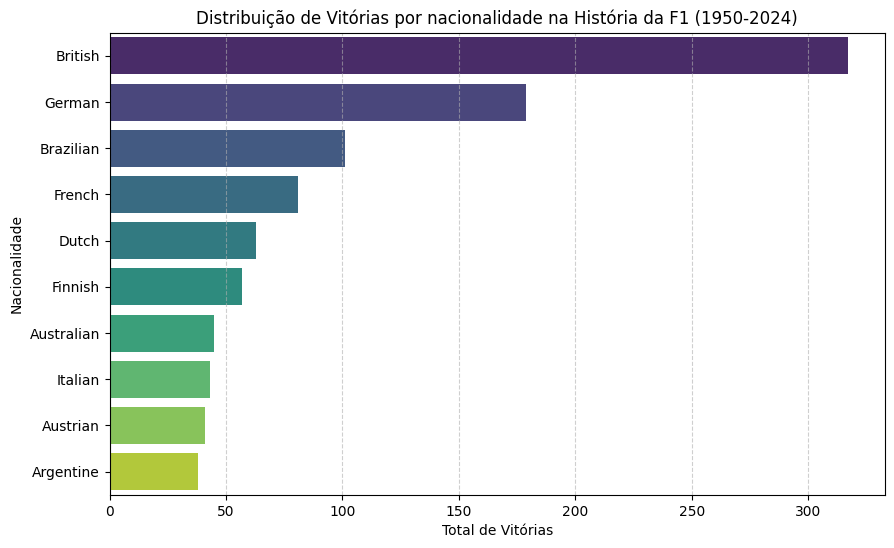

In [10]:
winners_df = results_df.filter(col("positionOrder") == 1)
winners_with_nationality = winners_df.join(drivers_df, "driverId", "inner")

nationality_wins_spark = (
    winners_with_nationality
    .groupBy("nationality")
    .agg(count("*").alias("Total_Wins"))
    .orderBy(desc("Total_Wins"))
    .limit(10)
)

nationality_wins_pd = nationality_wins_spark.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="Total_Wins", y="nationality", hue="nationality", data=nationality_wins_pd, palette="viridis", legend=False)
plt.title('Distribuição de Vitórias por nacionalidade na História da F1 (1950-2024)')
plt.xlabel('Total de Vitórias')
plt.ylabel('Nacionalidade')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

___

### Heatmap sobre relação entre posição de largada e chegada

Na seguinte visualização, temos uma plotagem de um heatmap para alocação dos dados referentes à posição de largada e de chegada



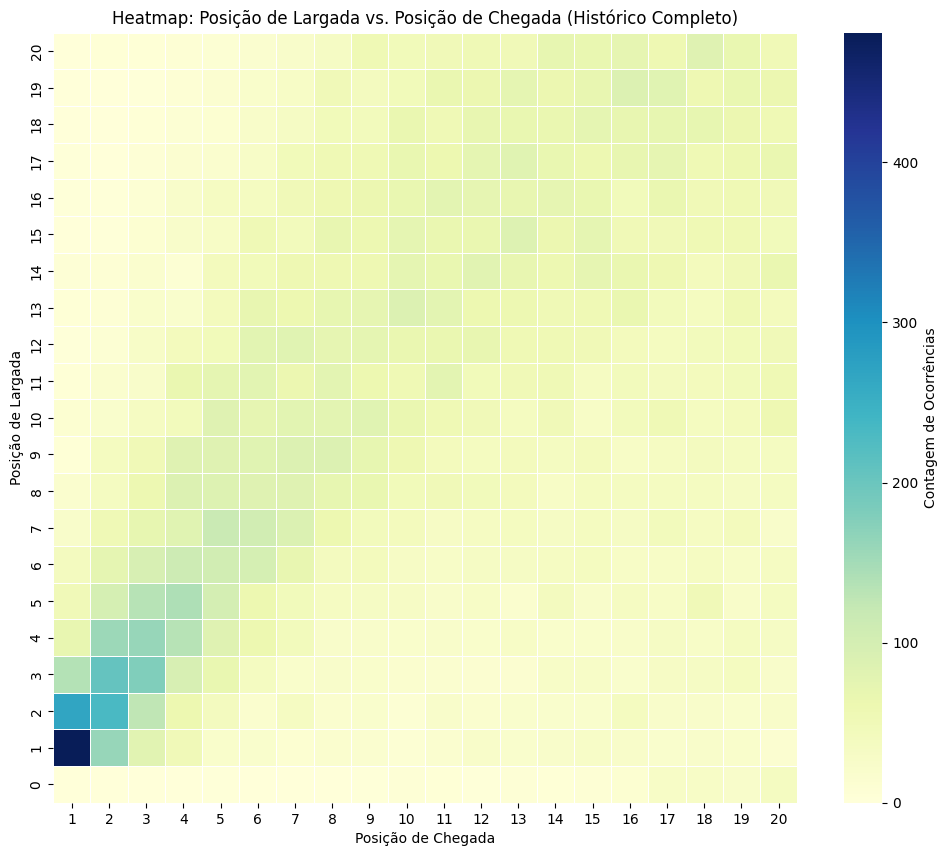

In [ ]:
grid_vs_position_spark = (
    results_df
    .groupBy("grid", "positionOrder")
    .agg(count("*").alias("Count"))
)

grid_vs_position_pd = grid_vs_position_spark.toPandas()

heatmap_data = grid_vs_position_pd.pivot_table(
    index='grid', 
    columns='positionOrder', 
    values='Count'
).fillna(0)

max_pos = 20
heatmap_data = heatmap_data.loc[:max_pos, :max_pos]

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=False, 
    fmt=".0f",
    linewidths=.5,
    cbar_kws={'label': 'Contagem de Ocorrências'}
)

plt.title('Heatmap: Posição de Largada vs. Posição de Chegada (Histórico Completo)')
plt.xlabel('Posição de Chegada')
plt.ylabel('Posição de Largada')
plt.gca().invert_yaxis() 
plt.show()


___

### Heatmap alocando informações de vitorias por nacionalidade

Esta célula faz uma verificação da alocaçãod dos dados na tabela results_df para ver como os dados estão organizados

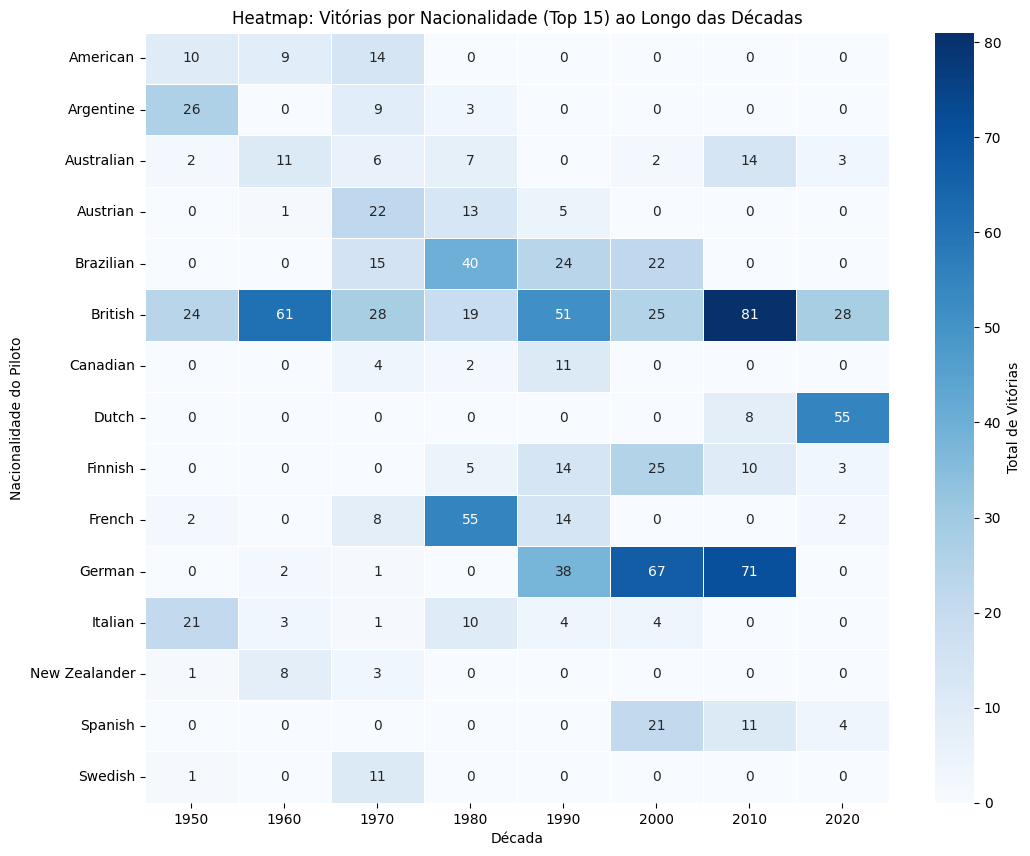

In [ ]:
nationality_wins_spark = (
    results_df
    .filter(col("positionOrder") == 1) # Filtra apenas vencedores
    .join(drivers_df, "driverId", "inner")
    .join(races_df, "raceId", "inner")
    .withColumn("decade", floor(col("year") / lit(10)) * lit(10))
    .groupBy("nationality", "decade")
    .agg(count("*").alias("Total_Wins"))
)

nationality_wins_pd = nationality_wins_spark.toPandas()

top_nationalities = (
    nationality_wins_pd
    .groupby('nationality')['Total_Wins']
    .sum()
    .nlargest(15)
    .index
    .tolist()
)

heatmap_data_nationality = nationality_wins_pd[nationality_wins_pd['nationality'].isin(top_nationalities)]

# Pivotagem: Nacionalidade (Linhas) vs. Década (Colunas)
heatmap_pivot = heatmap_data_nationality.pivot_table(
    index='nationality', 
    columns='decade', 
    values='Total_Wins'
).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_pivot,
    cmap="Blues",
    annot=True, 
    fmt=".0f",
    linewidths=.5,
    cbar_kws={'label': 'Total de Vitórias'}
)

plt.title('Heatmap: Vitórias por Nacionalidade (Top 15) ao Longo das Décadas')
plt.xlabel('Década')
plt.ylabel('Nacionalidade do Piloto')
plt.show()

___

### Gráfico de barras - Pilotos por nacionalidade

Esta célula utiliza o PySpark para agregar os dados do drivers_df e em seguida plotar um gráfico de barras

/tmp/ipykernel_21427/3906964827.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Driver_Count", y="nationality", data=nationality_count_pd, palette="viridis")


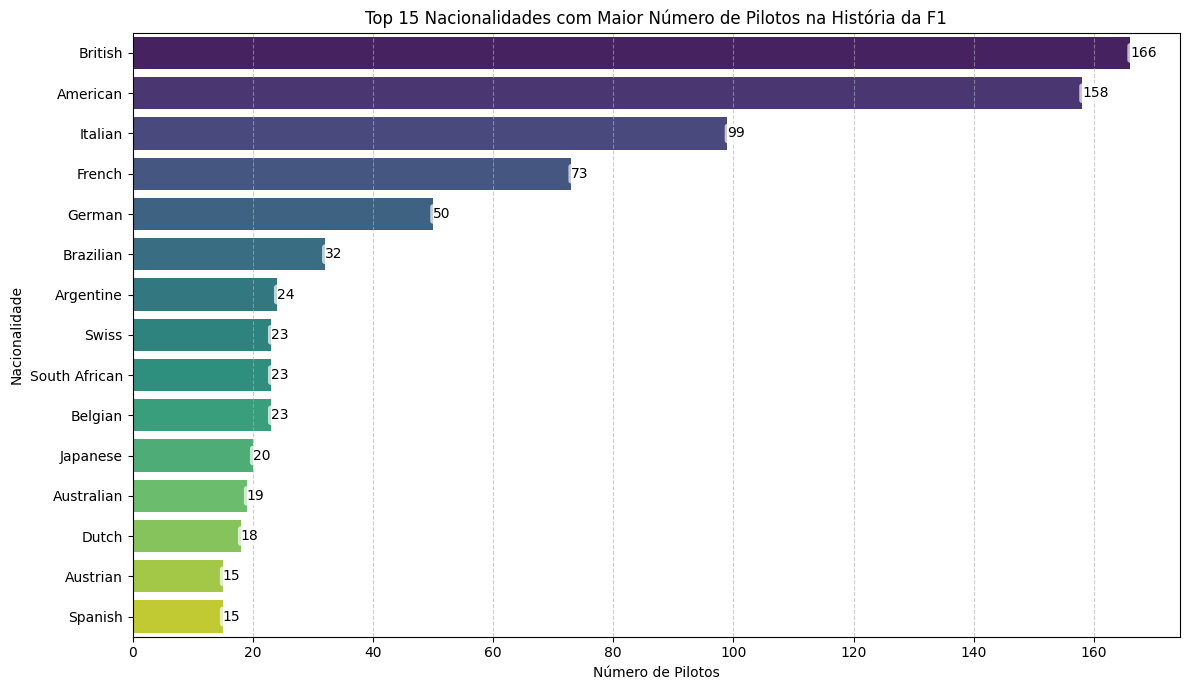

In [ ]:

nationality_count_spark = (
    drivers_df
    .groupBy("nationality")
    .agg(count("*").alias("Driver_Count"))
    .orderBy(col("Driver_Count").desc())
    .limit(15)
)

nationality_count_pd = nationality_count_spark.toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(x="Driver_Count", y="nationality", data=nationality_count_pd, palette="viridis")
plt.title('Top 15 Nacionalidades com Maior Número de Pilotos na História da F1')
plt.xlabel('Número de Pilotos')
plt.ylabel('Nacionalidade')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

for index, row in nationality_count_pd.iterrows():
    plt.text(row['Driver_Count'], index, f'{row["Driver_Count"]}', 
             va='center', ha='left', fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

plt.show()